In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [3]:
from efficientnet.tfkeras import EfficientNetB2
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
import numpy as np
import utils_tf1
from glob import glob
import cv2
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.layers import concatenate

def convolution_block(x, filters, size, strides=(1, 1), padding='same', activation=True, training=True):
    x = tf.keras.layers.Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    if activation == True:
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    return x


def residual_block(blockInput, num_filters=16, training=True):
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(blockInput)
    x = tf.keras.layers.BatchNormalization()(x)
    blockInput = tf.keras.layers.BatchNormalization()(blockInput, training=training)
    x = convolution_block(x, num_filters, (3, 3))
    x = convolution_block(x, num_filters, (3, 3), activation=False)
    x = tf.math.add(x, blockInput)
    return x

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * tf.reduce_sum(intersection) + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

class Model:
    def __init__(self, img_size=256, dropout_rate=0.25, training=True,):
        self.X = tf.placeholder(tf.float32, (None, img_size, img_size, 3))
        X = tf.identity(self.X, name = 'input')
        backbone = EfficientNetB2(weights='imagenet',
                                  include_top=False,
                                  input_tensor=X)
        self.efficientnet = backbone
        start_neurons = 16

        # [B, 16, 16, 160]
        conv4 = backbone.layers[224].output
        conv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(conv4)
        pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
        pool4 = tf.keras.layers.Dropout(dropout_rate)(pool4, training=training)
        # [B, 8, 8, 160]

        # [B, 8, 8, 512]
        convm = tf.keras.layers.Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
        convm = residual_block(convm, start_neurons * 32, training=training)
        convm = residual_block(convm, start_neurons * 32, training=training)
        # [B, 8, 8, 512]
        convm = tf.keras.layers.LeakyReLU(alpha=0.1)(convm)

        # [B, 16, 16, 256]
        deconv4 = tf.keras.layers.Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
        uconv4 = concatenate([deconv4, conv4])
        # [B, 16, 16, 416]
        uconv4 = tf.keras.layers.Dropout(dropout_rate)(uconv4, training=training)

        # [B, 16, 16, 256]
        uconv4 = tf.keras.layers.Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
        uconv4 = residual_block(uconv4, start_neurons * 16)
        uconv4 = residual_block(uconv4, start_neurons * 16)
        # [B, 16, 16, 256]
        uconv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv4)

        # [B, 32, 32, 128]
        deconv3 = tf.keras.layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
        # [B, 32, 32, 56]
        conv3 = backbone.layers[108].output
        # [B, 32, 32, 184]
        uconv3 = concatenate([deconv3, conv3])
        uconv3 = tf.keras.layers.Dropout(dropout_rate)(uconv3, training=training)

        # [B, 32, 32, 128]
        uconv3 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
        uconv3 = residual_block(uconv3, start_neurons * 8)
        uconv3 = residual_block(uconv3, start_neurons * 8)
        # [B, 32, 32, 128]
        uconv3 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv3)

        # [B, 64, 64, 64]
        deconv2 = tf.keras.layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
        # [B, 64, 64, 32]
        conv2 = backbone.layers[65].output
        # [B, 64, 64, 96]
        uconv2 = concatenate([deconv2, conv2])
        uconv2 = tf.keras.layers.Dropout(0.1)(uconv2, training=training)

        # [B, 64, 64, 64]
        uconv2 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
        uconv2 = residual_block(uconv2, start_neurons * 4, training=training)
        uconv2 = residual_block(uconv2, start_neurons * 4, training=training)
        uconv2 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv2)

        # [B, 128, 128, 32]
        deconv1 = tf.keras.layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
        # [B, 128, 128, 24]
        conv1 = backbone.layers[22].output
        # [B, 128, 128, 66]
        uconv1 = concatenate([deconv1, conv1])
        uconv1 = tf.keras.layers.Dropout(0.1)(uconv1, training=training)

        # [B, 128, 128, 32]
        uconv1 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
        uconv1 = residual_block(uconv1, start_neurons * 2, training=training)
        uconv1 = residual_block(uconv1, start_neurons * 2, training=training)
        uconv1 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv1)

        # [B, 256, 256, 16]
        uconv0 = tf.keras.layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)
        uconv0 = tf.keras.layers.Dropout(0.1)(uconv0, training=training)
        uconv0 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
        uconv0 = residual_block(uconv0, start_neurons * 1, training=training)
        uconv0 = residual_block(uconv0, start_neurons * 1, training=training)
        uconv0 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv0)

        uconv0 = tf.keras.layers.Dropout(dropout_rate/2)(uconv0, training=training)
        self.logits = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(uconv0)
        self.logits = tf.identity(self.logits, name = 'logits')

In [5]:
tf.compat.v1.reset_default_graph()
model = Model()

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [6]:
checkpoint_file = 'efficientnetb2-unet-pembalakan/model.ckpt-10000'
var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
assignment_map, initialized_variable_names = utils_tf1.get_assignment_map_from_checkpoint(var_list, 
                                                                                          checkpoint_file)


INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:  name = stem_conv/kernel:0, shape = (3, 3, 3, 32), *INIT_FROM_CKPT*
INFO:tensorflow:  name = stem_bn/gamma:0, shape = (32,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = stem_bn/beta:0, shape = (32,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = stem_bn/moving_mean:0, shape = (32,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = stem_bn/moving_variance:0, shape = (32,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = block1a_dwconv/depthwise_kernel:0, shape = (3, 3, 32, 1), *INIT_FROM_CKPT*
INFO:tensorflow:  name = block1a_bn/gamma:0, shape = (32,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = block1a_bn/beta:0, shape = (32,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = block1a_bn/moving_mean:0, shape = (32,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = block1a_bn/moving_variance:0, shape = (32,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = block1a_se_reduce/kernel:0, shape = (1, 1, 32, 8), *INIT_FROM_CKPT*
INFO:tensorflow:  name = block1a_se_reduc

In [7]:
saver = tf.train.Saver(var_list = assignment_map)
saver.restore(sess, checkpoint_file)

INFO:tensorflow:Restoring parameters from efficientnetb2-unet-pembalakan/model.ckpt-10000


In [8]:
def _parse_image_function(example_proto):
    image_feature_description = {
        "image": tf.compat.v1.FixedLenFeature([], tf.string),
        "mask": tf.compat.v1.FixedLenFeature([], tf.string),
    }
    features = tf.compat.v1.parse_single_example(example_proto, features=image_feature_description)
    image = tf.image.decode_png(features['image'], channels = 3)
    image = tf.image.resize(image, [512, 512])
    image = tf.cast(image, tf.float32) / 255.0
    features['image'] = image
    mask = tf.io.decode_raw(features['mask'], out_type="float")
    mask = tf.reshape(mask, [512, 512, 3])
    mask = tf.cast(mask, tf.float32)
    features['mask'] = mask
    return features

dataset_path = glob('content/gdrive/MyDrive/Dataset/*.tfrec')
raw_image_dataset = tf.data.TFRecordDataset(dataset_path)
dataset = raw_image_dataset.map(_parse_image_function)
dataset = dataset.make_one_shot_iterator().get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [9]:
r = sess.run(dataset)
mask = np.zeros_like(r['mask'])
mask[:,:,1] = 1
mask = cv2.bitwise_and(r['mask'], mask)[:,:,1:2]

In [10]:
r['image'].shape, mask.shape

((512, 512, 3), (512, 512, 1))

In [7]:
from skimage.transform import resize

img_resize = resize(r['image'], (256, 256), anti_aliasing=False)
mask_resize = resize(mask, (256, 256), anti_aliasing=False)

NameError: name 'r' is not defined

In [12]:
logits = sess.run(model.logits, feed_dict = {model.X: [img_resize]})
logits.shape

(1, 256, 256, 1)

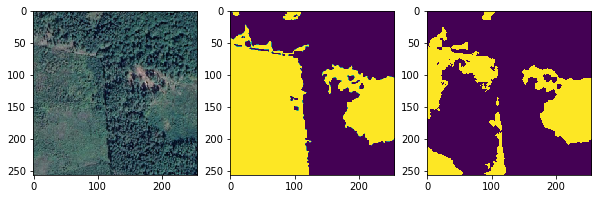

In [13]:
plt.figure(figsize = (10, 5))
plt.subplot(1,3,1)
plt.imshow(img_resize)
plt.subplot(1,3,2)
plt.imshow(mask_resize[:,:,0])
plt.subplot(1,3,3)
plt.imshow(np.around(logits[0,:,:,0]))

In [29]:
from skimage.io import imread
image = imread('perak.png')
img_resize = resize(image, (256, 256), anti_aliasing=False)
logits = sess.run(model.logits, feed_dict = {model.X: [img_resize]})
logits.shape

(1, 256, 256, 1)

In [8]:
from skimage.io import imread
image = imread('perak.png')
img_resize = resize(image, (1024, 1024), anti_aliasing=False)

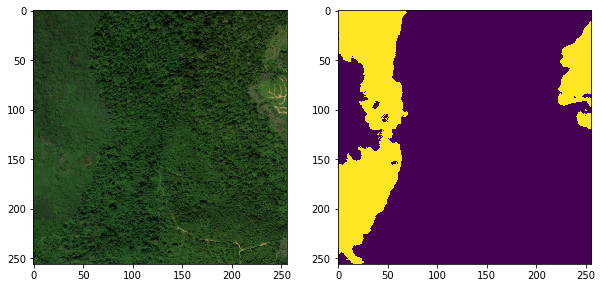

In [30]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(img_resize)
plt.subplot(1,2,2)
plt.imshow(np.around(logits[0,:,:,0]))

In [16]:
saver = tf.train.Saver()
saver.save(sess, 'b2/model.ckpt')

'b2/model.ckpt'

In [17]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'gather' in n.op.lower()
        or n.name == 'input'
        or 'logits' in n.name
        or 'seq_lens' in n.name)
        and 'adam' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
        and 'ReadVariableOp' not in n.name
        and 'Gather' not in n.name
    ]
)
strings.split(',')

['input', 'logits']

In [18]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [19]:
freeze_graph('b2', strings)

INFO:tensorflow:Restoring parameters from b2/model.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 487 variables.
INFO:tensorflow:Converted 487 variables to const ops.
3212 ops in the final graph.


In [20]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
                
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
        
    return graph

In [21]:
g = load_graph('b2/frozen_model.pb')
X = g.get_tensor_by_name('import/input:0')
logits = g.get_tensor_by_name('import/logits:0')

In [22]:
test_sess = tf.Session(graph = g)

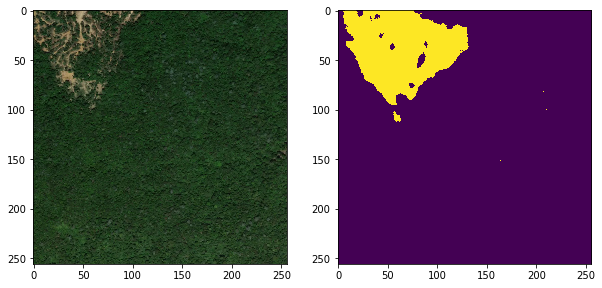

In [23]:
r = test_sess.run(logits, feed_dict = {X: [img_resize]})
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(img_resize)
plt.subplot(1,2,2)
plt.imshow(np.around(r[0,:,:,0]))

In [24]:
from tensorflow.tools.graph_transforms import TransformGraph

In [25]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics, op=Dropout)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-10, fallback_max=10)',
             'strip_unused_nodes',
             'sort_by_execution_order']

pb = 'b2/frozen_model.pb'

input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           ['input'],
                                           ['logits'], transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

Instructions for updating:
Use tf.gfile.GFile.


In [27]:
!cp efficientnetb2-unet-pembalakan/events.out.tfevents* b2
!cp efficientnetb2-unet-pembalakan/graph.pbtxt b2

In [28]:
!cp b2/* pembalakan/efficientnet-b2/